In [1]:
import transformer_lens
import torch
#import numpy as np 

c:\Users\durrc\OneDrive\Desktop\mech_interp_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
system_size=4

In [3]:
cfg = transformer_lens.HookedTransformerConfig(
    d_model=32,
    d_head = 8,
    n_layers=2,
    n_ctx=1+system_size,
    n_heads = 4,
    d_mlp = None,
    d_vocab=3,
    act_fn=None,
    attn_only=True,
    d_vocab_out=1
)

hooked_model = transformer_lens.HookedTransformer(
    cfg
)


In [4]:
def adapt_hooked_model(hooked_model):
    # give the hooked model params that are assumed to exist
    hooked_model.system_size = hooked_model.cfg.n_ctx-1
    hooked_model.system_sizes = [hooked_model.system_size]
    hooked_model.param_range = None
    hooked_model.embedding_size = hooked_model.cfg.d_model
    hooked_model.n_head = hooked_model.cfg.n_heads
    hooked_model.n_layers = hooked_model.cfg.n_layers
    hooked_model.size_idx=0
    


In [5]:
adapt_hooked_model(hooked_model)

In [6]:
from pruned_tqs.Hamiltonian import Ising
from pruned_tqs.optimizer import Optimizer

In [ ]:
system_size = hooked_model.system_size

Hamiltonians = [Ising(system_size, periodic=False)]

param_dim = Hamiltonians[0].param_dim

c:\Users\durrc\OneDrive\Desktop\mech_interp_project\quantum_mech_interp\pruned_tqs\Hamiltonian_utils.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  system_size = torch.tensor(system_size, dtype=torch.int64).reshape(-1)


In [ ]:
Hamiltonians[0].param_range

tensor([[0.5000],
        [1.5000]])

In [ ]:
iii = Ising(4, periodic=False)

c:\Users\durrc\OneDrive\Desktop\mech_interp_project\quantum_mech_interp\pruned_tqs\Hamiltonian_utils.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  system_size = torch.tensor(system_size, dtype=torch.int64).reshape(-1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ws, vs = np.linalg.eigh(iii.full_H(-1).todense())

In [ ]:
np.kron(1, np.eye(2))

array([[1., 0.],
       [0., 1.]])

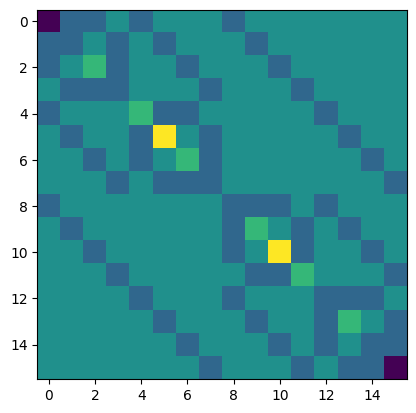

In [ ]:
plt.imshow(iii.full_H(-1).todense())

In [ ]:
Z = np.array([[1, 0], [0,-1]])
X = np.array([[0, 1], [1, 0]])
Ident = np.array([[1, 0], [0, 1]])



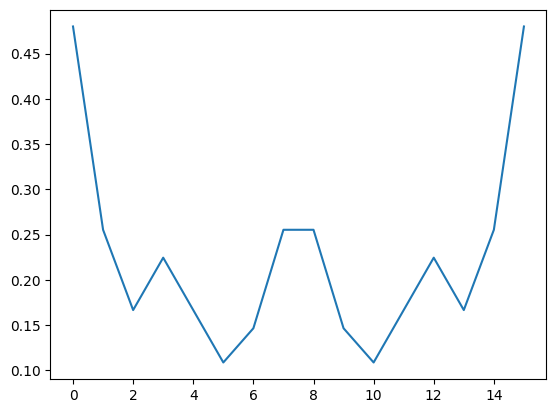

In [ ]:
plt.plot(np.abs(vs[:,0]))

In [ ]:
Hamiltonians[0].param_range *= 0
Hamiltonians[0].param_range +=1.0

In [ ]:
optim = Optimizer(hooked_model, Hamiltonians, point_of_interest=None)

In [ ]:
Hamiltonians[0].param_range[0,0].item()

1.0

In [ ]:
Hamiltonians[0].symmetry

In [ ]:
hooked_model.param_range

(tensor(1.), tensor(1.))

In [ ]:
optim.train(
    5000,
    batch=1000, #1000000,
    max_unique=10,
    param_range=None, # use the hamiltonian's
    fine_tuning=False,
    use_SR=False,
    ensemble_id=int(False),
)

this is param range (1.0, 1.0)
i = 0	 E_real = 59.995907	 E_imag = 0.000001	 E_var = 800660.875000	 n = 4	 lr = 4.3933e-07 t = 0.471858  t_optim = 0.095915
this is param range (1.0, 1.0)
i = 1	 E_real = 59.067413	 E_imag = -0.000003	 E_var = 771466.687500	 n = 4	 lr = 8.7866e-07 t = 0.382895  t_optim = 0.104068
this is param range (1.0, 1.0)
i = 2	 E_real = 57.464767	 E_imag = -0.000003	 E_var = 735582.750000	 n = 4	 lr = 1.3180e-06 t = 0.375865  t_optim = 0.089631
this is param range (1.0, 1.0)
i = 3	 E_real = 56.389168	 E_imag = -0.000002	 E_var = 721815.125000	 n = 4	 lr = 1.7573e-06 t = 0.439552  t_optim = 0.126828
this is param range (1.0, 1.0)
i = 4	 E_real = 55.720108	 E_imag = -0.000003	 E_var = 674727.375000	 n = 4	 lr = 2.1966e-06 t = 0.838838  t_optim = 0.195518
this is param range (1.0, 1.0)
i = 5	 E_real = 55.066235	 E_imag = 0.000002	 E_var = 684746.562500	 n = 4	 lr = 2.6360e-06 t = 0.645155  t_optim = 0.179729
this is param range (1.0, 1.0)
i = 6	 E_real = 56.327477	 E_

KeyboardInterrupt: 

In [ ]:
optim.model.evaluate_log_prob(
    1, 
    torch.tensor([[1,1,1,1]])
)

tensor([-24.6783], grad_fn=<SumBackward1>)

In [ ]:
optim.model.evaluate_log_prob(
    1, 
    torch.tensor([[0,1,0,1]])
)

tensor([-10.4883], grad_fn=<SumBackward1>)

In [ ]:
vals = []
for i in range(2**4):
    b = bin(i)[2:]
    b = '0'*(4-len(b))+b 
    vals.append([float(int(x)) for x in b])

0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111


In [ ]:
outs = optim.model.evaluate_log_prob(
    1, 
    torch.tensor(vals)
)

In [ ]:
from pruned_tqs import model_utils

In [ ]:
outs.shape

torch.Size([16])

In [ ]:
to_plot=model_utils.compute_psi(optim.model, samples=torch.tensor(vals).T, symmetry=Hamiltonians[0].symmetry)

In [ ]:
to_plot[0].detach()

tensor([-1.0039, -2.3625, -2.5346, -4.8528, -2.5346, -1.8379, -1.6547, -2.3625,
        -2.3625, -1.6547, -1.8379, -2.5346, -4.8528, -2.5346, -2.3625, -1.0039])

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

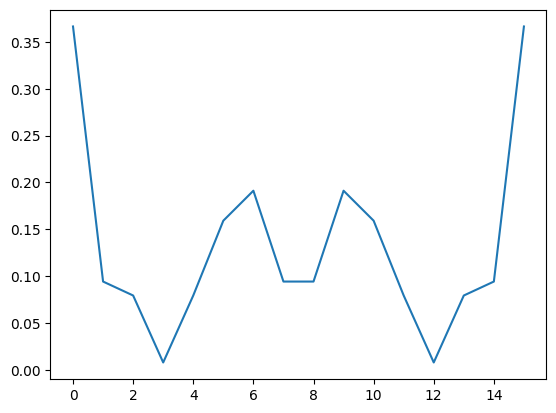

In [ ]:
plt.plot(np.exp(to_plot[0].detach()))

In [ ]:
Hamiltonians[0].full_H().todense()

matrix([[-3.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 1., -1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  1.,  1., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  1.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  1.,  0.,  1.,
          0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
          1.,  0.,  0.],
        [ 

In [ ]:
ws, vs = np.linalg.eigh(Hamiltonians[0].full_H().todense())

In [ ]:
Hamiltonians[0]

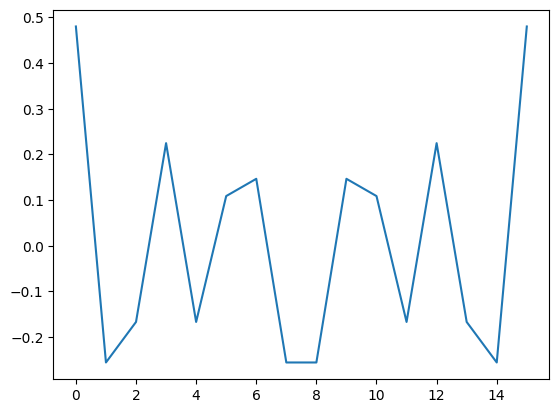

In [ ]:
plt.plot(vs[:, 0])

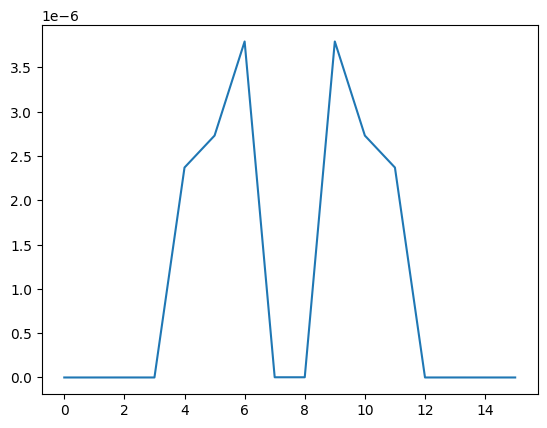

In [ ]:
plt.plot(np.exp(outs.detach().numpy()+outs.detach().numpy()[::-1]))